In [28]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


%matplotlib inline
from IPython.display import display
import time

# Possibly Redundant
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# Questions


### 🟡Step 1: Read the data (tar.gz file)
As a first step, we unzipped the tar.gz file into a .dat file using 7-zip. 
Then, we convert the .dat file into a string and then into a DataFrame.

#### Method 1 
.strip() --> remove spaces on the sides

.split() --> separate values by spaces (otherwise we'd get a single conlumn)

In [2]:
# Convert .dat file into string (list comprehension)
datContent = [i.strip().split() for i in open("tth_semihad.dat").readlines()]

# Convert string into DataFrame
mydata = pd.DataFrame(datContent)

### 🟡Step 2: Explore the data
**Physics**

"The file was produced from a simulation of pp->tt~H where the top decays hadronically
and the anti-top decays leptonically. I selected events with exactly 1 fat jet with R=1.5."


**Notes**

- The rows represent events. 
- The first column represents the number of constituents. 
- The following columns represent the coordinates of the constituents, η, φ, pT, cycling in that order. (e.g. columns 1, 2, 3 are η, φ, pT for the 1st constituent, columns 4, 5, 6 are η, φ, pT for the 2nd constituent etc.)
- -infinity < η < infinity 
- -π < φ < π
- pT[GeV] > 0



In [3]:
# Display the data
mydata = mydata.rename(columns={0: 'Const'})
display(mydata.head())

# Print statements
print('There are {} events.'.format(mydata.shape[0]))
print('The maximum number of constituents in an event is {}.'.format((mydata.shape[1] - 1) // 3))

# Display data types
#print('\nData Types: \n', mydata.dtypes)

# Descriptive statistics on data
#mydata.describe()

,Const,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,4,2.30474,0.221042,78.9436,1.00519,0.736657,61.9115,1.25546,0.748395,48.9755,...,None,None,None,None,None,None,None,None,None,None
1,2,2.35134,-2.18449,176.076,2.46233,-1.50073,47.3355,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,6,0.492933,0.766876,51.5247,-0.984489,2.29985,13.7463,0.103217,1.40088,5.31666,...,None,None,None,None,None,None,None,None,None,None
3,10,-0.624329,0.566723,130.197,-0.602316,0.573666,38.5226,-0.541426,0.449072,15.3244,...,None,None,None,None,None,None,None,None,None,None
4,15,-0.538961,-0.617644,0.819517,0.527734,1.53319,1.94989,0.20174,0.916744,5.63418,...,None,None,None,None,None,None,None,None,None,None


There are 12177 events.
The maximum number of constituents in an event is 36.


### 🟡Step 3: Construct Average Jet Image

Find local maxima using scipy, sklearn, matplotlib [Link here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html)

**Other Resources**
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
- https://towardsdatascience.com/image-filters-in-python-26ee938e57d2
- https://stackoverflow.com/questions/50747064/how-to-smooth-an-image-with-a-3x3-kernel

#### Task: For each row, extract the maximum pT and its corresponding η and φ.

then read 1407.5675

In [4]:
# Separate Constituents from Coordinates
const = mydata['Const']
mydata = mydata.drop('Const', axis=1)

# Fillna with 0
mydata = mydata.fillna(0)

# Convert values to floats
mydata = mydata.astype(float)

Separate pT and extract pT, φ, η 

In [6]:
# Separate η, φ, pT
hdata = mydata[mydata.columns[::3]]
fdata = mydata[mydata.columns[1::3]]
pdata = mydata[mydata.columns[2::3]]

In [20]:
# Extract column number of maximum pT
maxid = list(pdata.idxmax(axis=1))

maxlist = []

# Iterate through all rows(events) and all max pT columns to extract η, φ, pT
for rowno, colid in zip(range(mydata.shape[0]), maxid):
    maxlist.append([mydata.iloc[rowno, colid-1], mydata.iloc[rowno, colid-2], mydata.iloc[rowno, colid-3]])

# Create dataframe of maxima, η, φ
mydata_max = pd.DataFrame(maxlist, columns=['pT', 'φ', 'η'])

# Display DataFrame
display(mydata_max)

Time taken:  0.1962423324584961


,pT,φ,η
0,78.9436,0.221042,2.304740
1,176.0760,-2.184490,2.351340
2,111.4880,1.396430,-0.620303
3,130.1970,0.566723,-0.624329
4,258.9400,0.304648,0.191801
...,...,...,...
12172,67.6743,-0.505784,0.307106
12173,80.6389,-0.073204,-2.418710
12174,121.6040,-0.378084,1.392990
12175,148.5020,2.665060,1.192300


Plotting Preprocessing --> fillna0, astype(float), ndarray

In [33]:
df

,pT,φ
η,,
2.304740,78.9436,0.221042
2.351340,176.0760,-2.184490
-0.620303,111.4880,1.396430
-0.624329,130.1970,0.566723
0.191801,258.9400,0.304648
...,...,...
0.307106,67.6743,-0.505784
-2.418710,80.6389,-0.073204
1.392990,121.6040,-0.378084


In [34]:
df.columns = df['φ']
df

ValueError: Length mismatch: Expected axis has 2 elements, new values have 12177 elements

In [39]:
hm_df = pd.DataFrame(index=mydata_max['η'], columns=mydata_max['φ']) 

hm_df.values[[np.arange(df.shape[0])]*2] = mydata_max['pT']

hm_df = hm_df.fillna(0)

display(hm_df)

sb.heatmap(hm_df)

In [57]:
h = mydata_max['η']
f = mydata_max['φ']
p = mydata_max['pT']

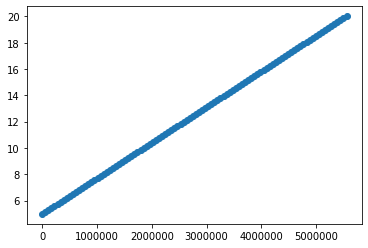

In [78]:
x = np.linspace(1, 5555555, 100)
y = np.linspace(5, 20, 100)

plt.scatter(x, y)

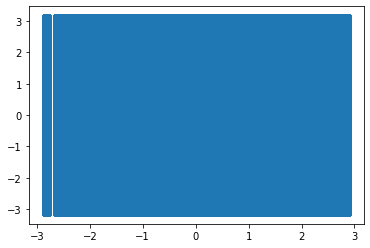

In [67]:
plt.scatter(h, f)

In [68]:
for i, x in enumerate(f):
    for j, y in enumerate(h):
        data[i, j] = some_function(x, y)

df = pd.DataFrame(p, index=Y, columns=X)

sns.heatmap(df)

NameError: name 'some_function' is not defined

In [21]:
# Convert df to ndarray
mydata_test = np.asarray(mydata_max)

In [55]:
df.astype(float)

φ,0.221042,-2.184490,1.396430,0.566723,0.304648,0.507969,-0.522596,-1.402150,3.031860,1.212440,...,-2.497030,-2.784140,-1.893350,-2.287040,0.585601,-0.505784,-0.073204,-0.378084,2.665060,-2.142970
η,,,,,,,,,,,,,,,,,,,,,
2.304740,78.9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.351340,NaN,176.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.620303,NaN,NaN,111.488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.624329,NaN,NaN,NaN,130.197,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.191801,NaN,NaN,NaN,NaN,258.94,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.307106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,67.6743,NaN,NaN,NaN,NaN
-2.418710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,80.6389,NaN,NaN,NaN
1.392990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.604,NaN,NaN


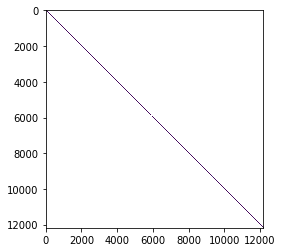

In [56]:
dff = df.astype(float)
dff = np.asarray(dff)
plt.imshow(dff)

In [ ]:
plt.imshow(data3[:109], cmap='hot', interpolation='nearest')

In [ ]:
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
pdataa[:50,:100] = pdataa[:50,:100]
result = ndimage.maximum_filter(pdataa[:50,:100], size=0)
ax1.imshow(pdataa[:50,:100])
ax2.imshow(result)
plt.show()

In [ ]:
im = pdataa[:50,:100]

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndimage.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [ ]:

im = img_as_float(data.coins())

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndimage.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [ ]:
import pickle
import gzip
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import scipy 

# from sklearn.preprocessing import scale
from sklearn import preprocessing

import h5py

import time

# Source https://github.com/SebastianMacaluso/Deep-learning_jet-images/blob/master/image_preprocess.py

In [ ]:
import dask.array as da
f = h5py.File('myfile.hdf5')
x = da.from_array(data, chunks=(1000, 1000))
x - x.mean(axis=1).compute()

da.tensordot(images, w, axes=(0, 0)).compute() / w.sum()

In [ ]:
import dask.array as da
f = h5py.File('myfile.hdf5')
x = da.from_array(f['/big-data'], chunks=(1000, 1000))
x - x.mean(axis=1).compute()

da.tensordot(images, w, axes=(0, 0)).compute() / w.sum()